In [307]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt

In [291]:
counts = pd.read_csv(r'C:\Users\hp\Downloads\Fremont_Bridge_Bicycle_Counter_20260216.csv')
weather = pd.read_csv(r'C:\Users\hp\Downloads\4231661.csv')

In [292]:
counts['Date'] = pd.to_datetime(counts['Date'], dayfirst=True, format='mixed')
counts.set_index('Date', inplace=True)

print(f'Info:\n{counts[['Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk',
       'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk']].info()}')

print(f'Description of:\n{counts.describe(include=['int', 'float'])}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 116867 entries, 2026-01-31 23:00:00 to 2012-02-10 13:00:00
Data columns (total 2 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  116838 non-null  float64
 1   Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk  116838 non-null  float64
dtypes: float64(2)
memory usage: 2.7 MB
Info:
None
Description of:
       Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk  \
count                                      116838.000000                    
mean                                           46.781903                    
std                                            60.378545                    
min                                             0.000000                    
25%         

In [293]:
print(f'Column Data Types[Counts]:\n{counts.dtypes}')
print(f'Column Data Types[Weather]:\n{weather.dtypes}')

Column Data Types[Counts]:
Fremont Bridge Sidewalks, south of N 34th St Total                     object
Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk    float64
Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk    float64
dtype: object
Column Data Types[Weather]:
STATION             object
NAME                object
LATITUDE           float64
LONGITUDE          float64
ELEVATION          float64
DATE                object
AWND               float64
AWND_ATTRIBUTES     object
FMTM               float64
FMTM_ATTRIBUTES     object
PGTM               float64
PGTM_ATTRIBUTES     object
PRCP               float64
PRCP_ATTRIBUTES     object
SNOW               float64
SNOW_ATTRIBUTES     object
SNWD               float64
SNWD_ATTRIBUTES     object
TAVG               float64
TAVG_ATTRIBUTES     object
TMAX                 int64
TMAX_ATTRIBUTES     object
TMIN               float64
TMIN_ATTRIBUTES     object
WDF2               float64
WDF2_ATTRIBUTES     ob

In [294]:
print(f'Columns with NaN values[Counts]:\n{counts.isna().sum()}')
print(f'Columns with NaN values[Weather]:\n{weather.isna().sum()}')

Columns with NaN values[Counts]:
Fremont Bridge Sidewalks, south of N 34th St Total                    29
Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk    29
Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk    29
dtype: int64
Columns with NaN values[Weather]:
STATION               0
NAME                  0
LATITUDE              0
LONGITUDE             0
ELEVATION             0
DATE                  0
AWND                 41
AWND_ATTRIBUTES      41
FMTM               5074
FMTM_ATTRIBUTES    5074
PGTM               4954
PGTM_ATTRIBUTES    4954
PRCP                  4
PRCP_ATTRIBUTES       4
SNOW                  0
SNOW_ATTRIBUTES       0
SNWD                  0
SNWD_ATTRIBUTES       0
TAVG                426
TAVG_ATTRIBUTES     426
TMAX                  0
TMAX_ATTRIBUTES       0
TMIN                  1
TMIN_ATTRIBUTES       1
WDF2                 41
WDF2_ATTRIBUTES      41
WDF5                 79
WDF5_ATTRIBUTES      79
WSF2                 41
WSF2_

In [295]:
counts = counts[['Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk',
       'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk']]

counts.rename(columns={'Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk': 'West', 'Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk': 'East'}, inplace=True)
counts['Total'] = counts.eval('West + East')


weather['Year'] = pd.to_datetime(weather['DATE']).dt.year
weather['Month'] = pd.to_datetime(weather['DATE']).dt.month
weather['Day'] = pd.to_datetime(weather['DATE']).dt.day

weather['DATE'] = pd.to_datetime(weather['DATE'])
weather.set_index('DATE', inplace=True)


In [296]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

# daily
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

In [297]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):

       days = (date - pd.to_datetime('21/12/2000', errors='coerce', dayfirst=True)).days
       m = (1. - np.tan(np.radians(latitude))
       * np.tan(np.radians(axis) *
       np.cos(days * 2 * np.pi / 365.25)))
       return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))

<Axes: title={'center': 'Dynamic of Daylight Hours'}, xlabel='Date', ylabel='Daily Hours'>

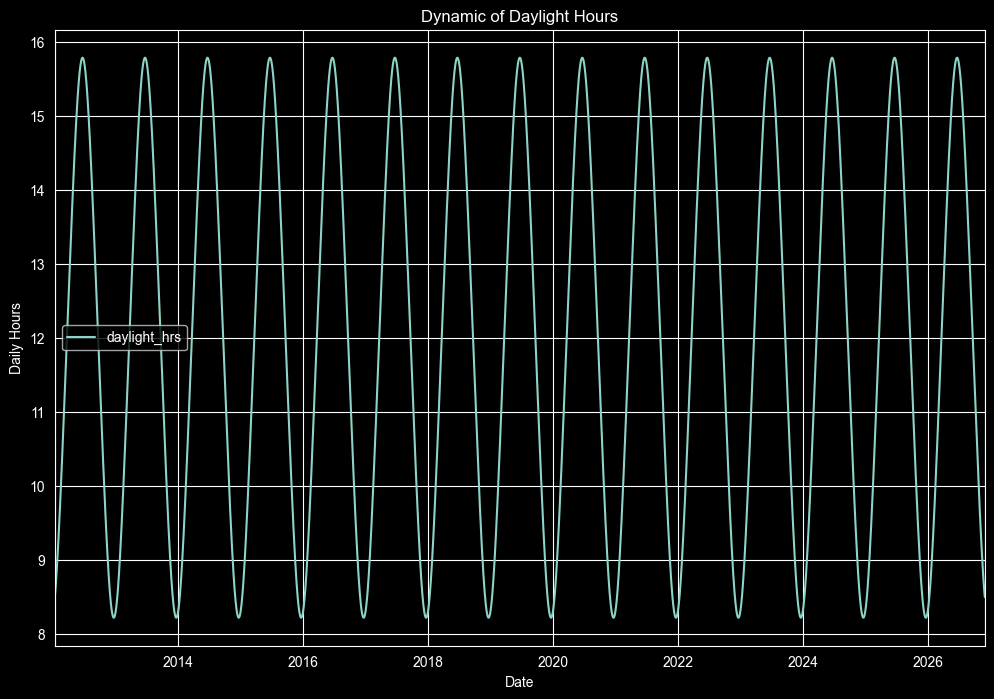

In [298]:
# plt.figure(figsize=(12, 8))
daily[['daylight_hrs']].plot(kind='line', figsize=(12, 8), title='Dynamic of Daylight Hours', xlabel='Date', ylabel='Daily Hours', grid=True)
# help(pd.Series.plot)

In [299]:
weather.index.name ='Date'
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['T(C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])


weather['PRCP'] /= 254
weather['dry_day'] = (weather['PRCP'] == 0).astype('int')

daily = daily.join(weather[['T(C)', 'dry_day', 'PRCP']], lsuffix='_l', rsuffix='_r')

daily['annual'] = (daily.index - daily.index[0]).days/365

# help(pd.DataFrame.join)


In [300]:
daily.columns

Index(['Total', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'T(C)', 'dry_day', 'PRCP', 'annual'],
      dtype='object')

In [309]:
# def standardize_nan(X: np.ndarray):
#     """Z-score each column ignoring NaNs. Returns standardized X and stats for possible inverse transform."""
#     mu = np.nanmean(X, axis=0)
#     sigma = np.nanstd(X, axis=0)
#     sigma = np.where(sigma == 0, 1.0, sigma)  # avoid divide-by-zero
#     return (X - mu) / sigma, mu, sigma
#
# def eval_knn_imputer_k(X_df: pd.DataFrame, k: int, mask_frac: float = 0.1, random_state: int = 0):
#     rng = np.random.default_rng(random_state)
#
#     X = X_df.to_numpy(dtype=float)
#     observed = ~np.isnan(X)
#
#     # Choose which observed entries to hide for validation
#     obs_pos = np.argwhere(observed)
#     n_hide = int(len(obs_pos) * mask_frac)
#     hide_idx = obs_pos[rng.choice(len(obs_pos), size=n_hide, replace=False)]
#
#     X_masked = X.copy()
#     true_vals = X_masked[hide_idx[:, 0], hide_idx[:, 1]]
#     X_masked[hide_idx[:, 0], hide_idx[:, 1]] = np.nan
#
#     # IMPORTANT: distance-based methods are sensitive to feature scale.
#     # Standardize using nan-aware stats computed on the masked data.
#     Xs, mu, sigma = standardize_nan(X_masked)
#
#     imputer = KNNImputer(n_neighbors=k, weights="distance")
#     Xs_imp = imputer.fit_transform(Xs)
#
#     # back to original scale
#     X_imp = Xs_imp * sigma + mu
#
#     pred_vals = X_imp[hide_idx[:, 0], hide_idx[:, 1]]
#
#     rmse = float(np.sqrt(np.mean((pred_vals - true_vals) ** 2)))
#     mae = float(np.mean(np.abs(pred_vals - true_vals)))
#     return rmse, mae

Best k by RMSE: 29


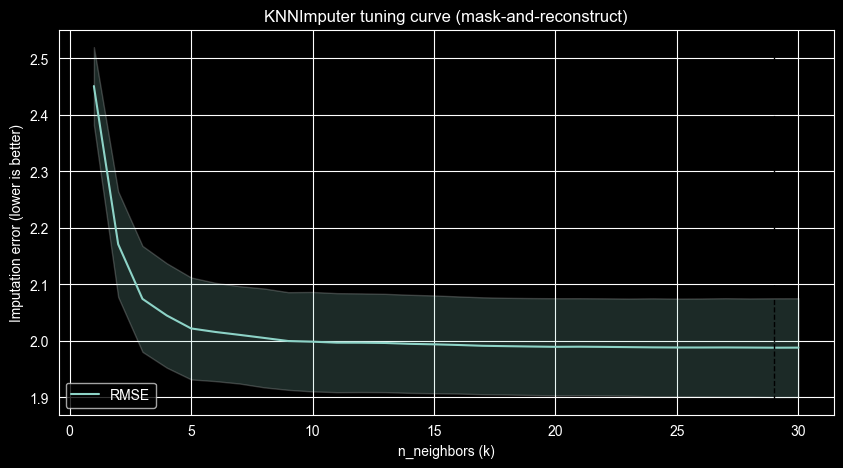

In [310]:
# cols = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
#         'daylight_hrs', 'T(C)', 'dry_day', 'PRCP', 'annual']
#
# X_df = daily[cols]
#
# k_values = list(range(1, 31))
# n_repeats = 5
#
# rmse_mean, rmse_std = [], []
# mae_mean, mae_std = [], []
#
# for k in k_values:
#     rmses, maes = [], []
#     for seed in range(n_repeats):
#         rmse, mae = eval_knn_imputer_k(X_df, k=k, mask_frac=0.1, random_state=seed)
#         rmses.append(rmse)
#         maes.append(mae)
#     rmse_mean.append(np.mean(rmses)); rmse_std.append(np.std(rmses))
#     mae_mean.append(np.mean(maes));   mae_std.append(np.std(maes))
#
# best_k = k_values[int(np.argmin(rmse_mean))]
# print("Best k by RMSE:", best_k)
#
# plt.figure(figsize=(10, 5))
# plt.plot(k_values, rmse_mean, label="RMSE")
# plt.fill_between(k_values,
#                  np.array(rmse_mean) - np.array(rmse_std),
#                  np.array(rmse_mean) + np.array(rmse_std),
#                  alpha=0.2)
# plt.axvline(best_k, linestyle="--", color="k", linewidth=1)
# plt.xlabel("n_neighbors (k)")
# plt.ylabel("Imputation error (lower is better)")
# plt.title("KNNImputer tuning curve (mask-and-reconstruct)")
# plt.grid(True)
# plt.legend()
# plt.show()

In [312]:
model = KNNImputer(n_neighbors=15)

daily[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'T(C)', 'dry_day', 'PRCP', 'annual']] = model.fit_transform(daily[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'T(C)', 'dry_day', 'PRCP', 'annual']])



In [313]:
columns_name = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
       'daylight_hrs', 'T(C)', 'dry_day', 'PRCP', 'annual']
target = 'Total'

X = daily[columns_name]
Y = daily[target]

model = LinearRegression(fit_intercept=False)
model.fit(X, Y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",False
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [318]:
daily['predicted'] = model.predict(X)

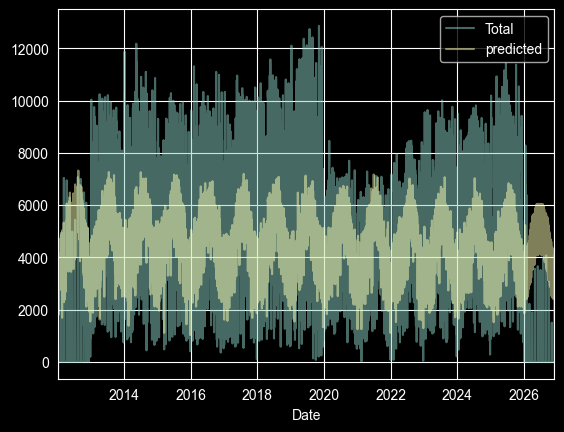

In [319]:
daily[['Total', 'predicted']].plot(alpha=0.5);

In [320]:
model.coef_[0]

np.float64(1478.2598747280929)